In [5]:
import os
import re
import torch
import random
import nltk
from pyvi import ViTokenizer
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

In [6]:
# 1. Tokenizers
def tokenize_en(text):
    return text.lower().strip().split()

def tokenize_vi(text):
    return ViTokenizer.tokenize(text.lower()).split()

In [7]:
# 2. Vocab builder
def build_vocab(tokenized_sentences, min_freq=2, specials=["<PAD>", "<SOS>", "<EOS>", "<UNK>"]):
    counter = Counter()
    for tokens in tokenized_sentences:
        counter.update(tokens)
    vocab = {token: idx for idx, token in enumerate(specials)}
    for token, freq in counter.items():
        if freq >= min_freq and token not in vocab:
            vocab[token] = len(vocab)
    return vocab

In [8]:
# 3. Encode sentence
def encode(tokens, vocab, sos="<SOS>", eos="<EOS>"):
    ids = [vocab.get(sos)]
    ids += [vocab.get(t, vocab.get("<UNK>")) for t in tokens]
    ids.append(vocab.get(eos))
    return ids

In [9]:
# 4. PyTorch Dataset
class TranslationDataset(Dataset):
    def __init__(self, src_lines, tgt_lines, src_vocab, tgt_vocab):
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src_tokens = tokenize_en(self.src_lines[idx])
        tgt_tokens = tokenize_vi(self.tgt_lines[idx])
        src_ids = torch.tensor(encode(src_tokens, self.src_vocab), dtype=torch.long)
        tgt_ids = torch.tensor(encode(tgt_tokens, self.tgt_vocab), dtype=torch.long)
        return src_ids, tgt_ids

In [10]:
# 5. Collate function
def collate_fn(batch, pad_idx):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=pad_idx, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=pad_idx, batch_first=True)
    return src_batch, tgt_batch

In [11]:
en_path=r"D:\Machine Translation\dataset\total\combined.en"
vi_path=r"D:\Machine Translation\dataset\total\combined.vi"

In [12]:
with open(en_path, encoding="utf-8") as f:
    en_lines = [line.strip() for line in f if line.strip()]
with open(vi_path, encoding="utf-8") as f:
    vi_lines = [line.strip() for line in f if line.strip()]

In [ ]:
# Check the length of the longest sentence
max_length_en = max(len(tokenize_en(sentence)) for sentence in en_lines)
max_length_vi = max(len(tokenize_vi(sentence)) for sentence in vi_lines)
print(f"Longest sentence length (English): {max_length_en}")
print(f"Longest sentence length (Vietnamese): {max_length_vi}")

# Check all the lengths in the dataset
lengths_en = [len(tokenize_en(sentence)) for sentence in en_lines]
lengths_vi = [len(tokenize_vi(sentence)) for sentence in vi_lines]
print(f"All sentence lengths (English): {set(lengths_en)}")
print(f"All sentence lengths (Vietnamese): {set(lengths_vi)}")

Longest sentence length (English): 625
Longest sentence length (Vietnamese): 880
All sentence lengths (English): {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 148, 150, 151, 152, 154, 157, 158, 159, 160, 161, 164, 165, 167, 168, 169, 170, 514, 173, 174, 176, 177, 178, 179, 181, 185, 190, 193, 194, 195, 202, 612, 208, 214, 216, 221, 553, 227, 229, 230, 232, 235, 237, 239, 241, 242, 557, 251, 260, 265, 269, 520, 288, 289, 296, 301, 309, 310,

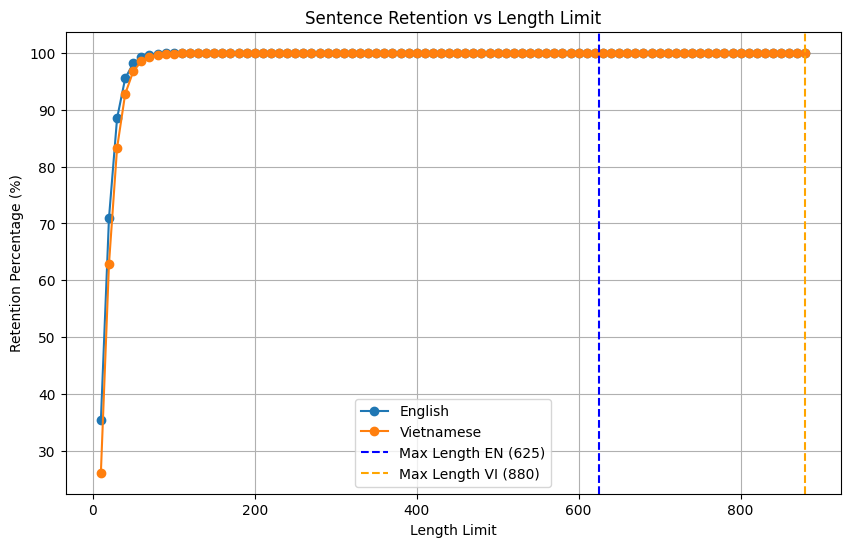

Length Limit: 40 | English Retention: 95.49% | Vietnamese Retention: 92.75%
Length Limit: 50 | English Retention: 98.14% | Vietnamese Retention: 96.74%
Length Limit: 60 | English Retention: 99.16% | Vietnamese Retention: 98.48%
Length Limit: 70 | English Retention: 99.61% | Vietnamese Retention: 99.23%
Length Limit: 80 | English Retention: 99.79% | Vietnamese Retention: 99.60%
Length Limit: 90 | English Retention: 99.88% | Vietnamese Retention: 99.77%
Length Limit: 100 | English Retention: 99.93% | Vietnamese Retention: 99.86%


In [20]:
import matplotlib.pyplot as plt

# Function to calculate the percentage of sentences retained for a given length limit
def calculate_retention(lengths, limit):
    return sum(1 for length in lengths if length <= limit) / len(lengths) * 100

# Define a range of length limits to analyze
length_limits = range(10, max(max_length_en, max_length_vi) + 1, 10)

# Calculate retention percentages for English and Vietnamese datasets
retention_en = [calculate_retention(lengths_en, limit) for limit in length_limits]
retention_vi = [calculate_retention(lengths_vi, limit) for limit in length_limits]

# Plot the retention percentages
plt.figure(figsize=(10, 6))
plt.plot(length_limits, retention_en, label="English", marker='o')
plt.plot(length_limits, retention_vi, label="Vietnamese", marker='o')
plt.axvline(x=max_length_en, color='blue', linestyle='--', label=f"Max Length EN ({max_length_en})")
plt.axvline(x=max_length_vi, color='orange', linestyle='--', label=f"Max Length VI ({max_length_vi})")
plt.title("Sentence Retention vs Length Limit")
plt.xlabel("Length Limit")
plt.ylabel("Retention Percentage (%)")
plt.legend()
plt.grid()
plt.show()

# Print retention percentages for specific thresholds
for limit in [40, 50, 60, 70, 80, 90, 100]:
    retention_en_limit = calculate_retention(lengths_en, limit)
    retention_vi_limit = calculate_retention(lengths_vi, limit)
    print(f"Length Limit: {limit} | English Retention: {retention_en_limit:.2f}% | Vietnamese Retention: {retention_vi_limit:.2f}%")

In [21]:
# 6. Main function
def preprocess_and_save(en_path, vi_path, save_path, batch_size=32, min_freq=2,
                        train_ratio=0.8, val_ratio=0.1, seed=42):
    print("🔄 Loading raw data...")
    with open(en_path, encoding="utf-8") as f:
        en_lines = [line.strip() for line in f if line.strip()]
    with open(vi_path, encoding="utf-8") as f:
        vi_lines = [line.strip() for line in f if line.strip()]

    assert len(en_lines) == len(vi_lines), "Số lượng câu không khớp!"

    MAX_LEN = 80

    filtered_en = []
    filtered_vi = []

    for en, vi in zip(en_lines, vi_lines):
        if len(en.split()) <= MAX_LEN and len(vi.split()) <= MAX_LEN:
            filtered_en.append(en)
            filtered_vi.append(vi)

    en_lines = filtered_en
    vi_lines = filtered_vi

    print("🔄 Tokenizing...")
    tokenized_en = [tokenize_en(line) for line in en_lines]
    tokenized_vi = [tokenize_vi(line) for line in vi_lines]

    print("🔄 Building vocabularies...")
    vocab_en = build_vocab(tokenized_en, min_freq)
    vocab_vi = build_vocab(tokenized_vi, min_freq)

    pad_idx = vocab_en["<PAD>"]

    print("🔄 Creating full dataset...")
    full_dataset = TranslationDataset(en_lines, vi_lines, vocab_en, vocab_vi)

    # 🔥 Chia tập train - val - test
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    print(f"📊 Dataset split: train={train_size}, val={val_size}, test={test_size}")

    # Đảm bảo chia reproducible
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size], generator=generator
    )

    print(f"💾 Saving to {save_path}")
    torch.save({
        "src_lines": {
            "train": [en_lines[i] for i in train_dataset.indices],
            "val": [en_lines[i] for i in val_dataset.indices],
            "test": [en_lines[i] for i in test_dataset.indices],
        },
        "tgt_lines": {
            "train": [vi_lines[i] for i in train_dataset.indices],
            "val": [vi_lines[i] for i in val_dataset.indices],
            "test": [vi_lines[i] for i in test_dataset.indices],
        },
        "vocab_en": vocab_en,
        "vocab_vi": vocab_vi,
        "pad_idx": pad_idx,
        "params": {
            "en_path": en_path,
            "vi_path": vi_path,
            "min_freq": min_freq,
            "batch_size": batch_size,
            "ratios": {
                "train": train_ratio,
                "val": val_ratio,
                "test": round(1 - train_ratio - val_ratio, 2)
            },
            "seed": seed
        }
    }, save_path)

    print("✅ Preprocessing & splitting done!")

In [22]:
preprocess_and_save(
    en_path=r"D:\Machine Translation\dataset\total\combined.en",
    vi_path=r"D:\Machine Translation\dataset\total\combined.vi",
    save_path=r"D:\Machine Translation\dataset\total\processed_data.pt",
    batch_size=32,
    min_freq=2
)

🔄 Loading raw data...
🔄 Tokenizing...
🔄 Building vocabularies...
🔄 Creating full dataset...
📊 Dataset split: train=262290, val=32786, test=32787
💾 Saving to D:\Machine Translation\dataset\total\processed_data.pt
✅ Preprocessing & splitting done!
